# Imports

In [76]:
import requests
import time
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

%matplotlib inline

# Fetching Data

The conspiracy and climate skeptics subreddits have about 840k and 11k subscribers respectively, with probably a lot of common subscribers. The goal of this section is to pull about 1000 posts from each subreddits in order to have data to effectively build a model to recognize trends accross titles and effectively classify them.

In [2]:
# Conspiracy and Climate Skeptics URLs
url = 'https://www.reddit.com/r/conspiracy/.json'
url_2 = 'https://www.reddit.com/r/climateskeptics/.json'

headers = {'User-agent' : 'Nour Zahlan'}

In [3]:
# Function to pull subreddit posts
def get_subreddit(url, n_pulls, headers):    

    # Create empty templates
    posts = []
    after = None

    # Create a loop that does max 25 requests per pull
    for pull_num in range(n_pulls):
        print("Pulling data attempted", pull_num+1,"time(s)")

        if after == None:
            new_url = url                 # base case
        else:
            new_url = url+"?after="+after # subsequent iterations

        res = requests.get(new_url, headers=headers)

        if res.status_code == 200:
            subreddit_json = res.json()                      # Pull JSON
            posts.extend(subreddit_json['data']['children']) # Get subreddit posts
            after = subreddit_json['data']['after']          # 'after' = ID of the last post in this iteration
        else:
            print("We've run into an error. The status code is:", res.status_code)
            break

        time.sleep(1)
        
    return(posts)

In [4]:
# Call function
conspiracy_data = get_subreddit(url, n_pulls = 41, headers = headers)
climate_data = get_subreddit(url_2, n_pulls = 41, headers = headers)

Pulling data attempted 1 time(s)
Pulling data attempted 2 time(s)
Pulling data attempted 3 time(s)
Pulling data attempted 4 time(s)
Pulling data attempted 5 time(s)
Pulling data attempted 6 time(s)
Pulling data attempted 7 time(s)
Pulling data attempted 8 time(s)
Pulling data attempted 9 time(s)
Pulling data attempted 10 time(s)
Pulling data attempted 11 time(s)
Pulling data attempted 12 time(s)
Pulling data attempted 13 time(s)
Pulling data attempted 14 time(s)
Pulling data attempted 15 time(s)
Pulling data attempted 16 time(s)
Pulling data attempted 17 time(s)
Pulling data attempted 18 time(s)
Pulling data attempted 19 time(s)
Pulling data attempted 20 time(s)
Pulling data attempted 21 time(s)
Pulling data attempted 22 time(s)
Pulling data attempted 23 time(s)
Pulling data attempted 24 time(s)
Pulling data attempted 25 time(s)
Pulling data attempted 26 time(s)
Pulling data attempted 27 time(s)
Pulling data attempted 28 time(s)
Pulling data attempted 29 time(s)
Pulling data attempted 

In [40]:
# Checking how many posts we got in each subreddit
print('Conspiracy: ', len(conspiracy_data))
print('Climate Skeptics: ', len(climate_data))

Conspiracy:  1011
Climate Skeptics:  1019


In [41]:
# Building Dataframes
conspiracy_dict = {'title' : [], 'source' : 'conspiracy'}
climate_dict = {'title' : [], 'source' : 'climate'}

for a in range(len(conspiracy_data)):
    conspiracy_dict['title'].append(conspiracy_data[a]['data']['title'])
    
for a in range(len(climate_data)):
    climate_dict['title'].append(climate_data[a]['data']['title'])
    

conspiracy_df = pd.DataFrame(conspiracy_dict)
climate_df = pd.DataFrame(climate_dict)
df = pd.concat([conspiracy_df, climate_df])

# EDA

Basic EDA where we check for missing values, which we shouldn't have any of since we built the dataframe ourselves, also the first five rows to see the formats of the titles and decide how we want to handle formating

In [42]:
# Check the first five rows of climate skeptics df
climate_df.head()

,title,source
0,Graph reveals devastating impact of CO2 emissi...,climate
1,How The Climate Consensus Was Created,climate
2,When they say the oil companies are against Ca...,climate
3,Carbon Dioxide Only Causes Climate Change in U...,climate
4,In 2009 James Hansen was the head of NASA Godd...,climate


In [43]:
# Check the first five rows of conspiracy df
conspiracy_df.head()

,title,source
0,Announcement: /r/conspiracy Is Accepting Moder...,conspiracy
1,Crips and Bloods march peacefully together in ...,conspiracy
2,ISISrael?,conspiracy
3,"KGB defector Yuri Bezmenov (1984): ""Exposure t...",conspiracy
4,Mystery remains over why Kim Foxx's office dis...,conspiracy


In [74]:
# Make sure we don't have any missing values
df.isna().sum()

title                0
source               0
source_conspiracy    0
predictions          0
dtype: int64

In [44]:
# making sure we have the right amount of documents
print('Conspiracy dataframe row number: ', conspiracy_df.shape[0])
print('Climate Skeptics dataframe row number: ', climate_df.shape[0])
print('Combined dataframe row number: ', df.shape[0])

Conspiracy dataframe row number:  1011
Climate Skeptics dataframe row number:  1019
Combined dataframe row number:  2030


# Cleaning

From our observations above, it makes sense to change the titles so that words that have the same meaning aren't counted as different, based on either punctuation or if it's a singular or plural. Which is why we change the titles to all lower case and lemmatize each word separately.
We could use either stemming or lemmatizing but we still want to observe trends and understandable topics in our titles, and stemming often results in roots of words that aren't in the dictionary and is too harsh overall, which is why lemmatizing is the better option.
We also get rid of special characters, numbers and punctuation, leaving only letter characters since we want to study language and punctuation often doesn't tell us much about meaning, so converting it to letter only makes it easier for later formating.

In [45]:
# Function to lemmatize strings
lemmatizer = WordNetLemmatizer()
def lemmatize_string(string_in):
    string_list = string_in.split()
    str_lemmatized = ''
    for i in range(len(string_list)):
        str_lemmatized = str_lemmatized + lemmatizer.lemmatize(string_list[i]) + ' '
    return str_lemmatized[:-1]

In [46]:
# make all titles lowercase, lemmatize the words and remove special characters and numbers
def clean_df(df):
    df['title'] = df['title'].map(lambda cell: cell.lower())
    df['title'] = df['title'].map(lambda cell: re.sub("[^a-z]", " ", cell))
    df['title'] = df['title'].map(lambda cell: lemmatize_string(cell))

clean_df(df)    
clean_df(conspiracy_df)
clean_df(climate_df)

# Create dummy column to use as target for the source class, the positive class is conspiracy
df['source_conspiracy'] = df['source'].map(lambda cell: 1 if cell == 'conspiracy' else 0)
df.head()

,title,source,source_conspiracy
0,announcement r conspiracy is accepting moder...,conspiracy,1
1,crips and bloods march peacefully together in ...,conspiracy,1
2,isisrael,conspiracy,1
3,kgb defector yuri bezmenov exposure t...,conspiracy,1
4,mystery remains over why kim foxx s office dis...,conspiracy,1


# More EDA

In [47]:
# inspired by Noah Christiansen
# Doing a count vectorizer to get individial word counts, 
# to get a sense of popular words in conspiracy subreddit
cvec = CountVectorizer(stop_words = 'english')
conspiracy_words = pd.DataFrame(cvec.fit_transform(conspiracy_df['title']).todense(),
                               columns = cvec.get_feature_names())

conspiracy_words.sum().sort_values().tail(20)

assange       22
cia           24
real          24
story         25
video         25
hussle        25
media         28
new           28
government    29
just          32
think         32
world         32
joe           33
years         33
nipsey        33
like          39
biden         44
trump         48
people        49
conspiracy    64
dtype: int64

In [48]:
# Doing a count vectorizer to get individial word counts, 
# to get a sense of popular words in climate skeptics subreddit
climate_words = pd.DataFrame(cvec.fit_transform(climate_df['title']).todense(),
                               columns = cvec.get_feature_names())

climate_words.sum().sort_values().tail(20)

record         22
data           23
amp            23
solar          26
ice            26
world          26
sea            27
scientists     28
earth          28
energy         29
carbon         30
years          31
deal           42
science        55
green          59
new            94
warming       107
global        109
change        207
climate       408
dtype: int64

In [49]:
# Doing a count vectorizer to get bigram counts, 
# to get a sense of popular topics in conspiracy and climate skeptics subreddit
cvec = CountVectorizer(stop_words = 'english', ngram_range=(2,2))
conspiracy_words_2 = pd.DataFrame(cvec.fit_transform(conspiracy_df['title']).todense(),
                               columns = cvec.get_feature_names())

climate_words_2 = pd.DataFrame(cvec.fit_transform(climate_df['title']).todense(),
                               columns = cvec.get_feature_names())

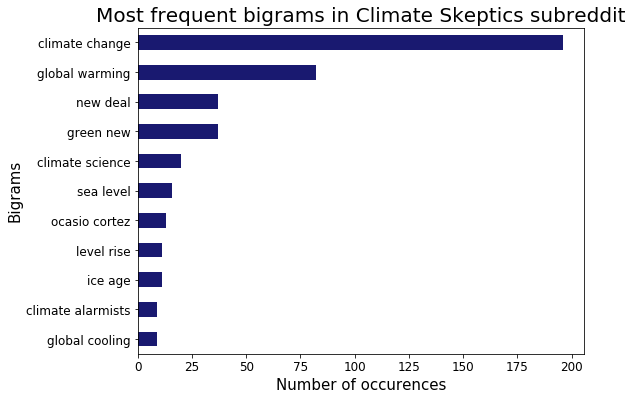

In [50]:
# plot bar graph of most popular bigrams to show number of occurences
plt.figure(figsize=(8,6))
plt.xlabel('Number of occurences', size=15)
plt.ylabel('Bigrams', size=15)
plt.title('Most frequent bigrams in Climate Skeptics subreddit', size=20)
climate_words_2.sum().sort_values().tail(11).plot('barh', color='midnightblue', fontsize=12);

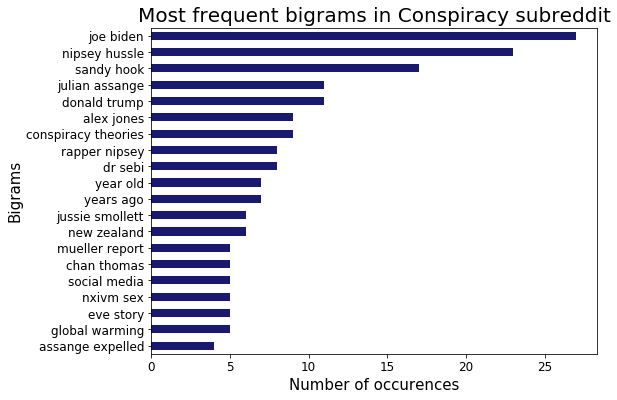

In [51]:
# plot bar graph of most popular bigrams to show number of occurences
plt.figure(figsize=(8,6))
plt.xlabel('Number of occurences', size=15)
plt.ylabel('Bigrams', size=15)
plt.title('Most frequent bigrams in Conspiracy subreddit', size=20)
conspiracy_words_2.sum().sort_values().tail(20).plot('barh', color='midnightblue', fontsize=12);

In [52]:
# Checking the number of words that appear in both dataframes
common = [a for a in conspiracy_words.columns if not (a in climate_words.columns)]
len(common)

2687

# Preprocessing and Modeling

## Preprocessing

Our only predictor here is our title column, and our target is our dummy source column where 1 corresponds to conspiracy and 0 corresponds to climate skeptics.

In [53]:
# Creating our X and y, train test split
X = df['title']
y = df['source_conspiracy']
accuracies = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [54]:
# Function to print out all the metrics used to evaluate models
def score_print(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('accuracy: ', accuracy_score(y_test, y_pred))
    print('misclassification: ', 1 - accuracy_score(y_test, y_pred))
    print('precision: ', precision_score(y_test, y_pred))
    print('recall: ', recall_score(y_test, y_pred))
    specificity = tn / (tn + fp)
    print('specificity: ', specificity)

### Baseline Accuracy

The majority class here is conspiracy since we have a little more posts coming from that subreddit. So if we were to predict conspiracy for all posts, we would correctly predict 50.7% of our observations.

In [55]:
# Baseline accuracy found by predicting the majority class
df['source_conspiracy'] = df['source'].map(lambda cell: 1 if cell == 'conspiracy' else 0)
df['source_conspiracy'].value_counts(normalize = True)

0    0.50197
1    0.49803
Name: source_conspiracy, dtype: float64

## Modeling

Using pipelines, we want to vectorize and tranforms our titles in a way that normal models like Logistic Regression can understand the dataset and be used to generate predicitons.
We have 2 choices for our vectorizers: Count Vectorizer and TF-IDF. They both tokenize the titles and separate them into words and then assign a value to that word. For count vectorizer, the value assigned is the number of times the word appears in the document. For TF-IDF it's the frequency at which the word appears in the document relative to the entire dataset, so the common words are given less weight than rare words, as the latter are thought to have more meaning.
Then we fit our models (Logistic Regression, Multinomial Naive Bayes and Random Trees) with our transformed datasets to effectively generate predictions. 
We use grid search here to be able to try a number of values for each parameter, and then check which values gave us the best performance by checking the cross value score for each set of parameter and selecting the best one.

### Logistic Regression and Count Vectorizer

In [56]:
# Instantiate pipeline with count vectorizer and logistic regression
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

# Parameters to try out
pipe_params = {
    'cvec__stop_words': [None, 'english', ['english']],
    'cvec__ngram_range': [(1,1), (1,2)], # also tried (1, 3)
    'cvec__max_features': [None, 1600, 1700],
    'cvec__token_pattern': [r'\w+'], #also tried default
    'cvec__max_df': [1.0, 0.8],
    'cvec__min_df': [1, 0.05],
    'lr__penalty': ['l2']
}

# instantiate grid search and finding out the best score and parameters
gs = GridSearchCV(pipe, param_grid = pipe_params, cv=3, verbose=1)
gs.fit(X_train, y_train)

print('Best score:', gs.best_score_)
print("Best params:", gs.best_params_)

# Printing train and test accuracy scores
print('train score:', gs.score(X_train, y_train))
print('test score:', gs.score(X_test, y_test))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/nourzahlan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best score: 0.8699080157687253
Best params: {'cvec__max_df': 1.0, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'cvec__token_pattern': '\\w+', 'lr__penalty': 'l2'}
train score: 0.9894875164257556
test score: 0.8956692913385826


[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:   17.0s finished


In [57]:
# generate predictions to calculate test set accuracy, misclassification, specificity, sensitivity, and precision
y_pred = gs.predict(X_test)

score_print(y_test, y_pred)

accuracies['lr_cvec'] = accuracy_score(y_test, y_pred)

accuracy:  0.8956692913385826
misclassification:  0.10433070866141736
precision:  0.8731343283582089
recall:  0.924901185770751
specificity:  0.8666666666666667


### Logistic Regression and TF-IDF Vectorizer

In [58]:
# Instantiate pipeline with TF-IDF vectorizer and logistic regression
pipe_1 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

# Parameters to try out
pipe_1_params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__max_features': [None, 1500, 1600],
    'tvec__token_pattern': [r'\w+'],
    'tvec__max_df': [1.0, 0.9],
    'tvec__min_df': [1, 0.01],
    'lr__penalty': ['l1', 'l2'] # also tried l1
}

# instantiate grid search and finding out the best score and parameters
gs_1 = GridSearchCV(pipe_1, param_grid = pipe_1_params, cv=3, verbose=1)
gs_1.fit(X_train, y_train)

print('Best score:', gs_1.best_score_)
print("Best params:", gs_1.best_params_)

# Printing train and test accuracy scores
print('train score:', gs_1.score(X_train, y_train))
print('test score:', gs_1.score(X_test, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/nourzahlan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best score: 0.878449408672799
Best params: {'lr__penalty': 'l2', 'tvec__max_df': 1.0, 'tvec__max_features': None, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english', 'tvec__token_pattern': '\\w+'}
train score: 0.9914586070959264
test score: 0.8996062992125984


[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:   20.1s finished


In [59]:
# generate predictions to calculate test set accuracy, misclassification, specificity, sensitivity, and precision
y_pred = gs_1.predict(X_test)

score_print(y_test, y_pred)
accuracies['lr_tvec'] = accuracy_score(y_test, y_pred)

accuracy:  0.8996062992125984
misclassification:  0.10039370078740162
precision:  0.8713235294117647
recall:  0.9367588932806324
specificity:  0.8627450980392157


### Multinomial NB and Count Vectorizer

In [60]:
# Instantiate pipeline with count vectorizer and multinomial naive bayes
pipe_2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

# Parameters to try out
pipe_2_params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__max_features': [1600, 1800, 1900],
    'cvec__token_pattern': [r'\w+'],
    'cvec__max_df': [1.0, 0.8],
    'cvec__min_df': [1, 0.05]
}

# instantiate grid search and finding out the best score and parameters
gs_2 = GridSearchCV(pipe_2, param_grid = pipe_2_params, cv=3, verbose=1)
gs_2.fit(X_train, y_train)

print('Best score:', gs_2.best_score_)
print("Best params:", gs_2.best_params_)

# Printing train and test accuracy scores
print('train score:', gs_2.score(X_train, y_train))
print('test score:', gs_2.score(X_test, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best score: 0.8771353482260184
Best params: {'cvec__max_df': 1.0, 'cvec__max_features': 1900, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'cvec__token_pattern': '\\w+'}
train score: 0.9507227332457293
test score: 0.8740157480314961


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:    9.4s finished


In [61]:
# generate predictions to calculate test set accuracy, misclassification, specificity, sensitivity, and precision
y_pred = gs_2.predict(X_test)

score_print(y_test, y_pred)
accuracies['mb_cvec'] = accuracy_score(y_test, y_pred)

accuracy:  0.8740157480314961
misclassification:  0.12598425196850394
precision:  0.895397489539749
recall:  0.8458498023715415
specificity:  0.9019607843137255


### Multinomial NB and TF-IDF Vectorizer

In [62]:
# Instantiate pipeline with TF-IDF vectorizer and multinomial naive bayes
pipe_3 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

# Parameters to try out
pipe_3_params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'tvec__max_features': [None, 1600, 2000],
    'tvec__token_pattern': [r'\w+'],
    'tvec__max_df': [1.0, 0.8],
    'tvec__min_df': [1, 0.05]
}

# instantiate grid search and finding out the best score and parameters
gs_3 = GridSearchCV(pipe_3, param_grid = pipe_3_params, cv=3, verbose=1)
gs_3.fit(X_train, y_train)

print('Best score:', gs_3.best_score_)
print("Best params:", gs_3.best_params_)

# Printing train and test accuracy scores
print('train score:', gs_3.score(X_train, y_train))
print('test score:', gs_3.score(X_test, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best score: 0.8876478318002629
Best params: {'tvec__max_df': 1.0, 'tvec__max_features': None, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english', 'tvec__token_pattern': '\\w+'}
train score: 0.9940867279894875
test score: 0.8759842519685039


[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:   19.8s finished


In [63]:
# generate predictions to calculate test set accuracy, misclassification, specificity, sensitivity, and precision
y_pred = gs_3.predict(X_test)

score_print(y_test, y_pred)
accuracies['mb_tvec'] = accuracy_score(y_test, y_pred)

accuracy:  0.8759842519685039
misclassification:  0.12401574803149606
precision:  0.9439252336448598
recall:  0.7984189723320159
specificity:  0.9529411764705882


### Random Forest and Count Vectorizer

In [64]:
# Instantiate pipeline with count vectorizer and random forest
pipe_4 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

# Parameters to try out
pipe_4_params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1,1), (1,3)], # also tried (1,2)
    'cvec__max_features': [None],
    'cvec__token_pattern': [r'\w+'],
    'cvec__max_df': [0.9, 0.8], # also tried 0.7, 1
    'cvec__min_df': [1], # also tried 0.05
    'rf__n_estimators': [500, 1000],
    'rf__max_depth': [None],
    'rf__min_samples_split': [3] # also tried 2, 4
}

# instantiate grid search and finding out the best score and parameters
gs_4 = GridSearchCV(pipe_4, param_grid = pipe_4_params, cv=3, verbose=1)
gs_4.fit(X_train, y_train)

print('Best score:', gs_4.best_score_)
print("Best params:", gs_4.best_params_)

# Printing train and test accuracy scores
print('train score:', gs_4.score(X_train, y_train))
print('test score:', gs_4.score(X_test, y_test))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  3.6min finished


Best score: 0.8607095926412615
Best params: {'cvec__max_df': 0.9, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'cvec__token_pattern': '\\w+', 'rf__max_depth': None, 'rf__min_samples_split': 3, 'rf__n_estimators': 500}
train score: 0.9980289093298291
test score: 0.8779527559055118


In [65]:
# generate predictions to calculate test set accuracy, misclassification, specificity, sensitivity, and precision
y_pred = gs_4.predict(X_test)

score_print(y_test, y_pred)
accuracies['rf_cvec'] = accuracy_score(y_test, y_pred)

accuracy:  0.8779527559055118
misclassification:  0.1220472440944882
precision:  0.8603773584905661
recall:  0.9011857707509882
specificity:  0.8549019607843137


### Random Forest and TF-IDF Vectorizer

In [66]:
# Instantiate pipeline with TF-IDF vectorizer and random forest
pipe_5 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# Parameters to try out
pipe_5_params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)], 
    'tvec__max_features': [None, 1500, 1600],
    'tvec__token_pattern': [r'\w+'],
    'tvec__max_df': [0.7], # also tried 1, 0.9,0.8, 0.6
    'tvec__min_df': [1], # also tried 0.05
    'rf__n_estimators': [500, 750], # also tried 1000
    'rf__max_depth': [None],
    'rf__min_samples_split': [3] # also tries 2, 4
}

# instantiate grid search and finding out the best score and parameters
gs_5 = GridSearchCV(pipe_5, param_grid = pipe_5_params, cv=3, verbose=1)
gs_5.fit(X_train, y_train)

print('Best score:', gs_5.best_score_)
print("Best params:", gs_5.best_params_)

# Printing train and test accuracy scores
print('train score:', gs_5.score(X_train, y_train))
print('test score:', gs_5.score(X_test, y_test))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  3.0min finished


Best score: 0.8600525624178712
Best params: {'rf__max_depth': None, 'rf__min_samples_split': 3, 'rf__n_estimators': 750, 'tvec__max_df': 0.7, 'tvec__max_features': 1500, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english', 'tvec__token_pattern': '\\w+'}
train score: 0.9921156373193167
test score: 0.889763779527559


In [67]:
# generate predictions to calculate test set accuracy, misclassification, specificity, sensitivity, and precision
y_pred = gs_5.predict(X_test)

score_print(y_test, y_pred)
accuracies['rf_tvec'] = accuracy_score(y_test, y_pred)

accuracy:  0.889763779527559
misclassification:  0.11023622047244097
precision:  0.8689138576779026
recall:  0.9169960474308301
specificity:  0.8627450980392157


# Evaluation

There are many metrics we can choose to evaluate our models on. If we cared more about building the conspiracy subreddit, then we would choose to optimize on sensitivity. If we care more about climate skeptics, then we would choose specificity. However here we care about both subreddits equaly, so we choose accuracy. We want most of our predictions to be true regardless of their source.

Here we compare the test set accuracy of our models, then after selecting the best one we want to evaluate it more in depth. 

The Logistic Regression model with TF-IDF vectorizer had the best accuracy score, with a 96.6% sensitivity, 87.5% specificity, and 88.1% precision. 

We also want to see trends in misclassified titles, so we want to find the most frequent bigrams in the false positives and the false negatives. Unsurprisingly, most climate change posts that originally came from conspiracy were misclassified.

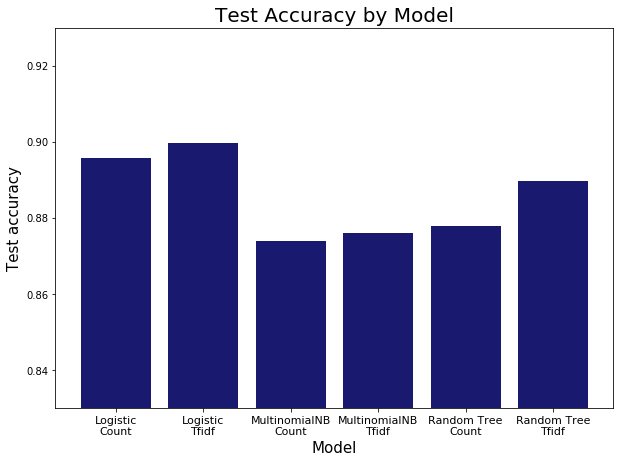

In [70]:
# plot of bar chart showing test score accuracy for each model built
plt.figure(figsize=(10,7))
plt.ylim(0.83, 0.93)
plt.xlabel('Model', size=15)
plt.ylabel('Test accuracy', size=15)
plt.title('Test Accuracy by Model', size=20)
plt.xticks(range(6), 
           labels=('Logistic\nCount', 'Logistic\nTfidf', 
                   'MultinomialNB\nCount', 'MultinomialNB\nTfidf', 
                   'Random Tree\nCount', 'Random Tree\nTfidf'), size=11)
plt.bar(accuracies.keys(), accuracies.values(), color='midnightblue');

In [73]:
# Choose best model with best test score accuracy and generate predictions for the entire df
df['predictions'] = gs_1.predict(X)

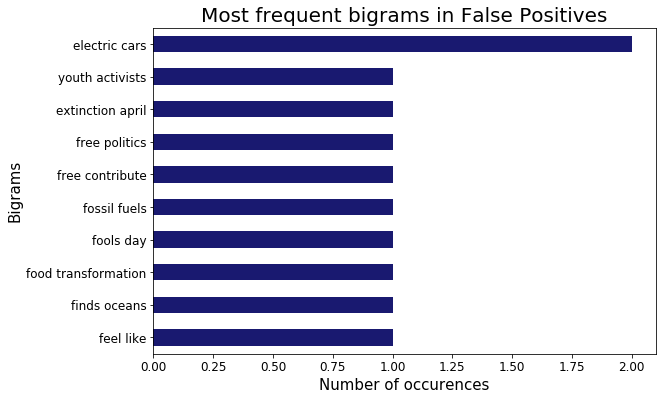

In [71]:
# To get a sense of topics most frequently misclassified as being from the 
# conspiracy subreddit when it was actually from Climate Skeptics
mask_fp = (df['predictions'] == 1) & (df['source_conspiracy'] == 0)
false_positives = df[mask_fp]

cvec = CountVectorizer(stop_words = 'english', ngram_range=(2,2))
fp_words = pd.DataFrame(cvec.fit_transform(false_positives['title']).todense(),
                               columns = cvec.get_feature_names())

plt.figure(figsize=(9,6))
plt.xlabel('Number of occurences', size=15)
plt.ylabel('Bigrams', size=15)
plt.title('Most frequent bigrams in False Positives', size=20)
fp_words.sum().sort_values().tail(10).plot('barh', color='midnightblue', fontsize=12);

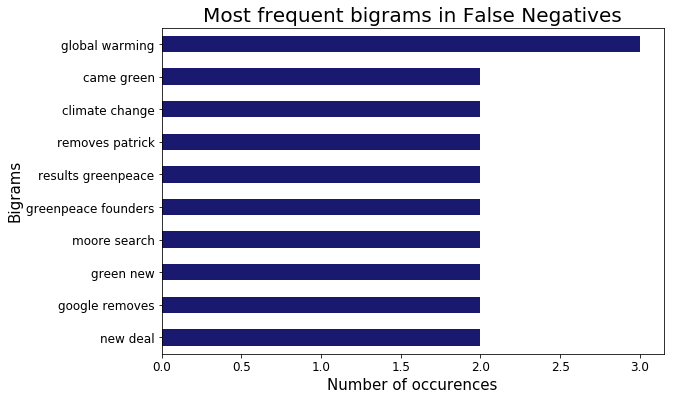

In [72]:
# To get a sense of topics most frequently misclassified as being from the 
# climate skeptics subreddit when it was actually from Conspiracy
mask_fn = (df['predictions'] == 0) & (df['source_conspiracy'] == 1)
false_negatives = df[mask_fn]

cvec = CountVectorizer(stop_words = 'english', ngram_range=(2,2))
fn_words = pd.DataFrame(cvec.fit_transform(false_negatives['title']).todense(),
                               columns = cvec.get_feature_names())

plt.figure(figsize=(9,6))
plt.xlabel('Number of occurences', size=15)
plt.ylabel('Bigrams', size=15)
plt.title('Most frequent bigrams in False Negatives', size=20)
fn_words.sum().sort_values().tail(10).plot('barh', color='midnightblue', fontsize=12);

# Conclusion

From the 6 models that we implemented, we were able to reconstruct the subreddits with 91% accuracy. The models were all similar in accuracy score on the test set (all in the range of 87% - 91%), even though they were all overfit, which we don't mind since the test score was still good. 